In [1]:
%matplotlib inline

In [187]:
from __future__ import print_function, division
import os, sys
import numpy as np, scipy as sp, pandas as pd
import scipy.io
import scipy.signal as signal, scipy.fftpack as ftpk, scipy.integrate as integrate, scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import matplotlib
# import tensorflow as tf
# import tflearn
from sklearn import linear_model as lm, neural_network as nn
from sklearn import preprocessing as preproc

original_dir = os.getcwd()

In [3]:
PLOT=True

In [4]:
e = np.exp(1)
pi = np.pi
pii = np.pi*1j
twopi = np.pi * 2
SR=400

In [5]:
import pywt
# import pyhht

In [6]:
from imp import reload
import glob

In [8]:
# os.chdir(original_dir + '/..')
os.chdir('/home/mm/py/kaggle/')
print(os.getcwd())
from eegkaggle.vectorizers import naive, spectral
from eegkaggle.dio import dataio
from eegkaggle.plotting import plotstuff
from eegkaggle.msignal import wavelets, metrics, auxfilter, msig

/home/mm/py/kaggle


In [214]:
reload(plotstuff)
reload(dataio)

<module 'eegkaggle.dio.dataio' from 'eegkaggle/dio/dataio.py'>

In [215]:
matplotlib.style.use('ggplot')

In [216]:
ssmall,smed, slarge, slong = (4,3), (8,6), (16,12), (16,4)
matplotlib.rcParams['figure.figsize'] = smed

Functions

In [222]:
def janky_subdiv(data, start=0, subdiv=64, chanVecSize=1024, nChan=16):
    if data.ndim == 3:
        return data[:,start::subdiv,:].reshape(-1,chanVecSize*nChan//subdiv)
    elif data.ndim == 2:
        raise NotImplementedError('dont use this')
        return data[:,start::subdiv]
    else:
        raise NotImplementedError("d'oh!")
        
class QuasiRobustScaler(object):
    def __init__(self, X=None, Y=None, normGlobal=True):
        pass
    def fit_transform(X, Y=None, normGlobal=True):
        pass
        

Data loading section

In [223]:
basedir = '/home/mm/data/vectors/'
data_train = np.load(basedir + 'vec_1478816228.31.npy')
names_train = pd.read_csv(basedir + 'vec_1478816228.31_name.csv')
data_test = np.load(basedir + 'vec_1478825795.45.npy')
names_test = pd.read_csv(basedir + 'vec_1478825795.45_name.csv')
print(data_train.shape, data_test.shape)

(6041, 1024, 16) (1908, 1024, 16)


In [224]:
data_train = np.nan_to_num(data_train)
data_test = np.nan_to_num(data_test)

In [225]:
names_train['label'] = [ int(name[-5]) for name in names_train['path']]
print(names_train.shape, names_train['label'].mean())
names_train.head()

(6041, 3) 0.0743254428075


,Unnamed: 0,path,label
0,0,/media/mike/Elements/data/kaggle/melbourne/tra...,0
1,1,/media/mike/Elements/data/kaggle/melbourne/tra...,0
2,2,/media/mike/Elements/data/kaggle/melbourne/tra...,0
3,3,/media/mike/Elements/data/kaggle/melbourne/tra...,0
4,4,/media/mike/Elements/data/kaggle/melbourne/tra...,0


In [226]:
name_mask = names_train['label'] == 0
name_mask1 = ~name_mask # not necessary, I just goof'd
print(name_mask.shape, name_mask.mean())
name_mask.head()

(6041,) 0.925674557193


0    True
1    True
2    True
3    True
4    True
Name: label, dtype: bool

In [227]:
# this section is suspect
# d0 = data_train * name_mask.reshape([6041,1,1])
# d1 = data_train* ~name_mask.reshape([6041,1,1])
# n0, n1 = np.count_nonzero(d0[:,512,0]), np.count_nonzero(d1[:,512,0])
# print(n0, n1)

In [228]:
# if PLOT: plt.plot(np.mean(np.mean(data_train, axis=2)==0, axis=1))

'Average (LOGT) power by channel'

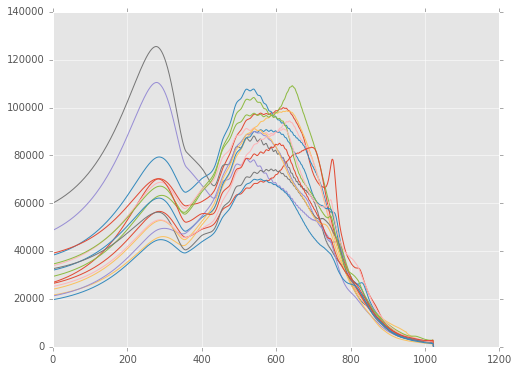

In [229]:
if PLOT: plt.plot(np.mean(data_train, axis=0))
'Average (LOGT) power by channel'

In [230]:
try:
    if PLOT: plt.plot(np.sum(d0, axis=0) / n0, c='k')
    if PLOT: plt.plot(np.sum(d1, axis=0) / n1, c='r')
except NameError:
    print('name not loaded')
'data set 0 vs 1'


name not loaded


'data set 0 vs 1'

In [231]:
try:
    if PLOT: plt.plot(np.mean(np.sum(d0, axis=0) / n0, axis=1), c='k')
    if PLOT: plt.plot(np.mean(np.sum(d1, axis=0) / n1, axis=1), c='r')
except NameError:
    print('name not loaded')

name not loaded


# NICE!

In [334]:
 # avg along electrodes
# simple_dtrain = np.mean(data_train, axis=2)
# simple_dtest = np.mean(data_test, axis=2)
subdiv = 64
simple_dtrain = data_train[:,::subdiv,:].reshape(-1,1024*16//subdiv)
simple_dtest = data_test[:,::subdiv,:].reshape(-1,1024*16//subdiv)
simple_dtrain = janky_subdiv(data_train, start=1)
simple_dtest = janky_subdiv(data_test, start=2)
simple_dtrain2 = janky_subdiv(data_train)
simple_dtest2 = janky_subdiv(data_test)
#insane sanity checking 

## THIS IS VERY SUSPECT
# Normalize ghetto style

# mean = np.array(np.median(simple_dtrain)) # deliberately not normalizing feature-wise
# std = np.array(np.std(simple_dtrain))
# simple_dtrain = simple_dtrain - mean
# simple_dtest = simple_dtest - std
# simple_dtrain = simple_dtrain / std 
# simple_dtest = simple_dtest / std

simple_dtrain2 = simple_dtrain2 - mean
simple_dtest2 = simple_dtest2 - std
simple_dtrain2 = simple_dtrain2 / std 
simple_dtest2 = simple_dtest2 / std

# homemade scaler
normo = dataio.NormOMatic(centerMode='med', normGlobal=True)
normo.fit(simple_dtrain)
simple_dtrain = normo.transform(simple_dtrain)
simple_dtest = normo.transform(simple_dtest)

# normo = preproc.RobustScaler()

print(simple_dtrain.shape, simple_dtest.shape)
print(np.mean(simple_dtrain))

(6041, 256) (1908, 256)
0.192916789559


In [335]:
# plt.plot(np.mean(simple_dtrain, axis=0))
# plt.plot(np.mean(simple_dtrain2, axis=0))

In [336]:
# plt.plot(np.mean(simple_dtrain, axis=0)/np.mean(simple_dtrain2, axis=0))

In [337]:
y = np.vstack([name_mask, ~name_mask]).T # label vector will be (N, S), N hot for 'no seiz', S hot for 'seize'
print(y.shape)

(6041, 2)


In [338]:
dtrain_set = np.concatenate([simple_dtrain, y], axis=1)
dtrain_set.shape

(6041, 258)

In [339]:
dframe = pd.DataFrame(dtrain_set)

In [340]:
d0 = dframe[dframe.iloc[:,-1] == 0]
d1 = dframe[dframe.iloc[:,-1] == 1]
print(d0.shape, d1.shape)
nfalse, nhit = d0.shape[0], d1.shape[0]

(5592, 258) (449, 258)


In [341]:
# randomly picks the zero datas... i think. the continuity may be essential
offset = np.random.randint(0, nfalse-nhit-1)
d0b = d0[offset:offset+nhit]
print(d0b.shape)

(449, 258)


In [342]:
d0b_ = d0b.as_matrix()
d1_ = d1.as_matrix()

d1_

array([[-0.72249266, -0.09354492, -0.15162856, ..., -0.93568862,
         0.        ,  1.        ],
       [-0.99188947, -0.05481912, -0.00417745, ..., -0.93635495,
         0.        ,  1.        ],
       [-0.70011188, -0.04322027,  0.97377749, ..., -0.93589594,
         0.        ,  1.        ],
       ..., 
       [-3.03524188, -0.96249792, -0.20170393, ..., -0.91910509,
         0.        ,  1.        ],
       [-1.71893668, -0.62503909,  0.036644  , ..., -0.91812655,
         0.        ,  1.        ],
       [-0.81207969, -0.48667838, -0.9226673 , ..., -0.92109658,
         0.        ,  1.        ]])

In [343]:
np.mean(simple_dtest, axis=None)

0.1109982521229702

### Shuffle and shit

In [344]:
subdiv_vec =1
new_set = np.concatenate([d0b_, d1_], axis=0)
print('new_set:',new_set.shape)
np.random.shuffle(new_set)
print(np.mean(new_set[:nhit,-1]))
simple_dtrain= new_set[:,:-2]
simple_dtrain_lab = new_set[:,-1]
simple_dtrain = simple_dtrain[:,::subdiv_vec]
print(simple_dtrain.shape)
print(np.mean(simple_dtrain_lab[:nhit]))


new_set: (898, 258)
0.503340757238
(898, 256)
0.503340757238


In [345]:
n = 1
# plt.plot(simple_dtrain[n])
# plt.plot(simple_dtest[n])

In [346]:
# Parition the data into training and evaluation sets
partition = 3*simple_dtrain.shape[0] // 4
print(partition)
print('simple_dtrain:', simple_dtrain.shape)
X=simple_dtrain[:partition]
Y=simple_dtrain_lab[:partition]
Xv=simple_dtrain[partition:]
Yv=simple_dtrain_lab[partition:]
G=simple_dtest


673
simple_dtrain: (898, 256)


In [347]:
print(Y.shape, np.mean(Y), np.mean(Yv))
print(X.shape, Y.shape, Xv.shape, Yv.shape)

(673,) 0.512630014859 0.462222222222
(673, 256) (673,) (225, 256) (225,)


In [348]:
# assert 0 # break point

In [349]:
# plt.plot(np.mean(X, axis=0))
# plt.plot(np.mean(Xv, axis=0))

In [350]:
# a = np.mean(X[:,:128], axis=1)
# b = np.mean(X[:,128:], axis=1)
# c = np.mean(Xv[:,:128], axis=1)
# d = np.mean(Xv[:,128:], axis=1)
# e = np.mean(G[:,:128], axis=1)
# f = np.mean(G[:,128:], axis=1)
# print(a.shape, b.shape)
# plt.scatter(a ,b,)
# plt.scatter(c, d, c='r', s=5, edgecolor='none')
# plt.scatter(e, f, c='g', s=5, edgecolor='none')

In [351]:
perc = lm.Perceptron()

In [352]:
cut = 250
sl = 2
kf = 4
X1, Y1 = X[::kf,:cut:sl], Y[::kf]
X2, Y2 = X[1::kf,:cut:sl], Y[1::kf]
G0 = G[:, :cut:sl]

In [353]:
print(X1.shape, Y1.shape, G0.shape, np.mean(Y, axis=0))
print(np.mean(X,), np.mean(Xv), np.std(Xv, ), np.std(Xv, ), )
print(np.mean(X1,), np.mean(X2), np.std(X1, ), np.std(X2, ), )

perc.fit(X1, Y1)

(169, 125) (169,) (1908, 125) 0.512630014859
0.0692132127625 0.0814098359097 0.881446930299 0.881446930299
0.109919265619 0.067689121602 0.849397558274 0.833159533201


Perceptron(alpha=0.0001, class_weight=None, eta0=1.0, fit_intercept=True,
      n_iter=5, n_jobs=1, penalty=None, random_state=0, shuffle=True,
      verbose=0, warm_start=False)

In [354]:
print( perc.score(Xv[:,:cut:sl], Yv), np.mean(Yv, axis=0))

0.857777777778 0.462222222222


In [355]:
print( perc.score(X1, Y1), np.mean(Yv, axis=0))
print( perc.score(X2, Y2), np.mean(Yv, axis=0))

0.887573964497 0.462222222222
0.809523809524 0.462222222222


In [356]:
pr = perc.predict(X2)
print('Expected: 0.5:',pr.mean())

Expected: 0.5: 0.422619047619


# VALIDATION

In [357]:
print('VALIDATION: ', np.mean(pr == Y2))

VALIDATION:  0.809523809524


In [ ]:
names_test['guess'] = pd.Series(pr)

In [ ]:
names_test['File'] = [os.path.basename(name) for name in names_test['path']]

In [ ]:
names_test.to_csv('guess11_10_perc.csv')

In [ ]:
ls

# SKLearn MLP

In [ ]:
mlp = nn.MLPClassifier(hidden_layer_sizes=(256,32,256,32), activation='relu', warm_start=1)

In [ ]:
mlp.fit(X, Y)
mlp.score(Xv, Yv)

In [ ]:
pr = mlp.predict(simple_dtest)
print(pr.mean())

In [ ]:
names_test['Class'] = pd.Series(pr)
names_test['File'] = [os.path.basename(name) for name in names_test['path']]

In [ ]:
assert 0, 'woah doggies'

In [ ]:
guessfile = names_test[['File', 'Class']]
guessfile.to_csv('guess11_10_mlp_256.csv', index=False)